In [ ]:
if 0:
    !nvidia-smi
    
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book
    
    from google.colab import drive
    drive.mount('/content/drive')

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PETS)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#5) [Path('image_gen'),Path('crappy'),Path('annotations'),Path('models'),Path('images')]

In [6]:
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [7]:
items = get_image_files(path_hr)

In [12]:
class Crappifier():
    def __init__(self, path_hr, path_lr, size):
        self.path_hr = path_hr
        self.path_lr = path_lr
        self.size = size
        
    def __call__(self, fn):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        target_sz = resize_to(img, self.size, use_min=True)
        img = img.resize(target_sz, resample=Image.BILINEAR).convert('RGB')
        img.save(dest, quality=60)

In [13]:
parallel(Crappifier(path_hr, path_lr, 96), items)
parallel(Crappifier(path_hr, path_mr, 256), items)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

In [14]:
path_lr.ls()

(#7390) [Path('small-96/Birman_115.jpg'),Path('small-96/leonberger_142.jpg'),Path('small-96/Bombay_68.jpg'),Path('small-96/japanese_chin_26.jpg'),Path('small-96/saint_bernard_149.jpg'),Path('small-96/Ragdoll_41.jpg'),Path('small-96/japanese_chin_32.jpg'),Path('small-96/Ragdoll_68.jpg'),Path('small-96/Persian_202.jpg'),Path('small-96/scottish_terrier_143.jpg')...]

In [15]:
path_mr.ls()

(#7390) [Path('small-256/Birman_115.jpg'),Path('small-256/leonberger_142.jpg'),Path('small-256/Bombay_68.jpg'),Path('small-256/japanese_chin_26.jpg'),Path('small-256/saint_bernard_149.jpg'),Path('small-256/Ragdoll_41.jpg'),Path('small-256/japanese_chin_32.jpg'),Path('small-256/Ragdoll_68.jpg'),Path('small-256/Persian_202.jpg'),Path('small-256/scottish_terrier_143.jpg')...]

In [16]:
path_hr.ls()

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

In [17]:
bs, size = 32, 128
arch = resnet34

In [26]:
def get_dls(path_lr, bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items = get_image_files,
        get_y = lambda x: path_hr/x.name,
        splitter = RandomSplitter(),
        item_tfms = Resize(size),
        batch_tfms = [*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)]
    )
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [27]:
dls = get_dls(path_lr, bs, size)

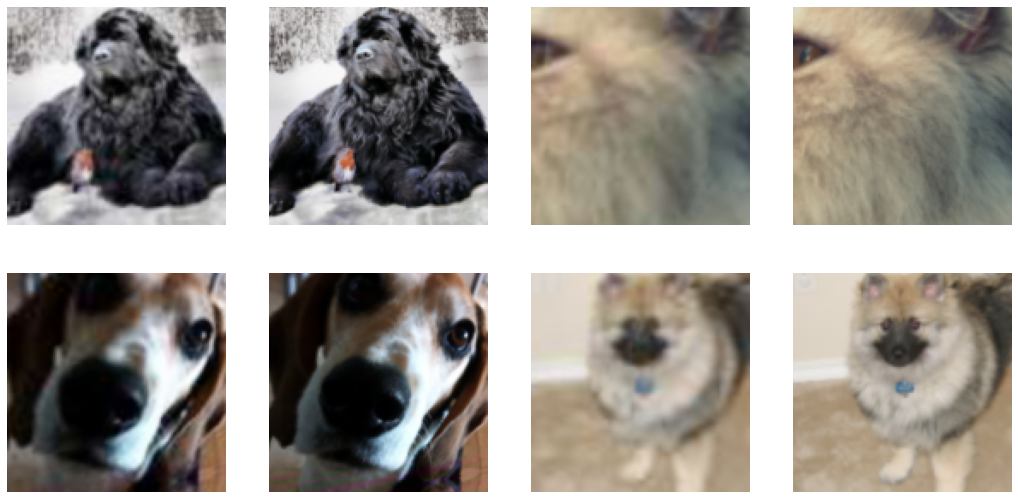

In [29]:
dls.show_batch(max_n=4, figsize=(18,9))

# Feature loss

In [31]:
t = tensor(dls.valid_ds[0][1]).float().permute(2,0,1)/255.
t = torch.stack([t,t])

In [32]:
t.shape

torch.Size([2, 3, 237, 237])

In [33]:
dls.valid_ds

(#1478) [(PILImage mode=RGB size=96x96, PILImage mode=RGB size=237x237),(PILImage mode=RGB size=143x96, PILImage mode=RGB size=500x335),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=120x96, PILImage mode=RGB size=500x400),(PILImage mode=RGB size=128x96, PILImage mode=RGB size=500x375),(PILImage mode=RGB size=96x144, PILImage mode=RGB size=333x500),(PILImage mode=RGB size=128x96, PILImage mode=RGB size=500x375),(PILImage mode=RGB size=116x96, PILImage mode=RGB size=500x413)...]

In [34]:
dls.valid_ds[0]

(PILImage mode=RGB size=96x96, PILImage mode=RGB size=237x237)

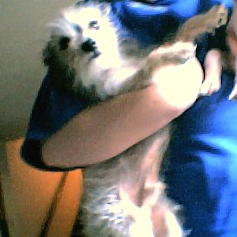

In [36]:
dls.valid_ds[0][1]

In [41]:
tensor(dls.valid_ds[0][1]).shape

torch.Size([237, 237, 3])

In [42]:
tensor(dls.valid_ds[0][1])

tensor([[[134, 139, 116],
         [133, 138, 115],
         [132, 137, 115],
         ...,
         [101, 105, 153],
         [ 98,  93, 123],
         [ 98,  91,  99]],

        [[131, 136, 113],
         [131, 136, 114],
         [130, 135, 115],
         ...,
         [107, 115, 154],
         [107, 105, 126],
         [109, 105, 106]],

        [[130, 135, 113],
         [129, 134, 114],
         [128, 133, 113],
         ...,
         [115, 126, 158],
         [116, 118, 131],
         [118, 119, 113]],

        ...,

        [[ 53,  76,  58],
         [ 25,  46,  31],
         [  4,  21,  11],
         ...,
         [ 57, 141, 255],
         [ 59, 140, 255],
         [ 58, 137, 255]],

        [[ 59,  82,  64],
         [ 29,  50,  35],
         [  5,  22,  12],
         ...,
         [ 60, 144, 255],
         [ 61, 143, 255],
         [ 59, 139, 254]],

        [[ 60,  83,  65],
         [ 30,  51,  36],
         [  6,  23,  13],
         ...,
         [ 61, 146, 255],
        

In [43]:
t

tensor([[[[0.5255, 0.5216, 0.5176,  ..., 0.3961, 0.3843, 0.3843],
          [0.5137, 0.5137, 0.5098,  ..., 0.4196, 0.4196, 0.4275],
          [0.5098, 0.5059, 0.5020,  ..., 0.4510, 0.4549, 0.4627],
          ...,
          [0.2078, 0.0980, 0.0157,  ..., 0.2235, 0.2314, 0.2275],
          [0.2314, 0.1137, 0.0196,  ..., 0.2353, 0.2392, 0.2314],
          [0.2353, 0.1176, 0.0235,  ..., 0.2392, 0.2392, 0.2275]],

         [[0.5451, 0.5412, 0.5373,  ..., 0.4118, 0.3647, 0.3569],
          [0.5333, 0.5333, 0.5294,  ..., 0.4510, 0.4118, 0.4118],
          [0.5294, 0.5255, 0.5216,  ..., 0.4941, 0.4627, 0.4667],
          ...,
          [0.2980, 0.1804, 0.0824,  ..., 0.5529, 0.5490, 0.5373],
          [0.3216, 0.1961, 0.0863,  ..., 0.5647, 0.5608, 0.5451],
          [0.3255, 0.2000, 0.0902,  ..., 0.5725, 0.5608, 0.5412]],

         [[0.4549, 0.4510, 0.4510,  ..., 0.6000, 0.4824, 0.3882],
          [0.4431, 0.4471, 0.4510,  ..., 0.6039, 0.4941, 0.4157],
          [0.4431, 0.4471, 0.4431,  ..., 0

In [44]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [45]:
gram_matrix(t)

tensor([[[0.0996, 0.0938, 0.0876],
         [0.0938, 0.0932, 0.0923],
         [0.0876, 0.0923, 0.0995]],

        [[0.0996, 0.0938, 0.0876],
         [0.0938, 0.0932, 0.0923],
         [0.0876, 0.0923, 0.0995]]])

In [46]:
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [47]:
base_loss = F.l1_loss

In [48]:
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m = vgg_m.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/sandmann/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [56]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [61]:
blocks[2:5]

[22, 32, 42]

In [64]:
class FeatureLoss(Module): # feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target, reduction=reduction)]
        self.feat_losses += [base_loss(f_in, f_out, reduction=reduction)*w 
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out), reduction=reduction)*w**2 * 5e3 
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
    def __del__(self): 
        self.hooks.remove()

In [65]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [69]:
learn = unet_learner(dls, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                    blur=True, norm_type=NormType.Weight)

In [70]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 1.20 GiB (GPU 0; 4.00 GiB total capacity; 536.39 MiB already allocated; 2.27 GiB free; 548.00 MiB reserved in total by PyTorch)